#### <b>Making predictions with our model</b>

This notebook pertains to making predictions with finetuned weights of our model (can use our weights on the repository, or can finetune the model yourself and use your own weights). For this, a few things are needed:
1. A folder with your PXRD data (in the form of a .npy file, please see ``experimental.ipynb``). This will be a nested numpy array that is in the form of ``[[2theta], [corresponding_intensities]]``
2. A folder with your precursor data (format: [metal_type][organic_linker] - both SMILES), with the files of each precursor strings for a MOF ending in .txt.
3. A path to your finetuned weights.
4. A list of CIFs (can be np.array or list type) - keep in mind that this list must be a subset of your ``directory_to_pxrd`` and ``directory_to_precursors`` folders i.e. they must have consistent naming. For instance, if we are predicting properties of MOF-5, the PXRD folder should contain MOF5.npy, precursor folder should contain MOF5.txt.

We will output predictions on methane uptake at HP from the BW20K dataset, as a quick demonstration.

In [1]:
# necessary libraries for convenience
import os
import shutil
import pandas as pd
import numpy as np
import pickle
import random
import torch
import yaml
import matplotlib.pyplot as plt

# import main module
from xraypro.setGen import create_loader
from xraypro.xraypro import XRayPro

# suppressing warnings (not recommended)
import warnings
warnings.simplefilter('ignore')

import sys
print(f'Python version: {sys.version}')

/home/sartaaj/miniconda3/envs/xraypro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]


If you run this entire notebook, you will eventually end with a folder called ``subset``, which will contain the PXRDs and the precursors that are tagged to the list of CIFs provided. For the sake of avoiding complications in overwriting files, it is simply best to automatically delete the ``subset`` folder.

In [7]:
# if subset folder exists, delete
folder_path = 'subset'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

Define your paths to your PXRD, precursor and weights folders. Furthermore, import a configuration file which contains the hyperparameters of the transformer for the precursor. For demonstration purposes, 100 random MOFs were sampled from the BW20K test set.

In [8]:
directory_to_pxrd = 'data/bw20k/pxrd'
directory_to_precursors = 'data/bw20k/precursors'
directory_to_cif_ids = 'data/bw20k/splits/CH4UptakeHP/test_cifs.pickle'
directory_to_weights = 'zenodo/weights/bw20k/model_pure_uptake_methane_298.00_6500000_ft.pth'

yaml_path = os.path.join('xraypro', 'transformer_precursor', 'config_ft_transformer.yaml')
yaml_data = os.path.join('xraypro', 'transformer_precursor', 'config_data.yaml')
config = yaml.load(open(yaml_path, "r"), Loader=yaml.FullLoader)

with open(directory_to_cif_ids, 'rb') as handle:
    cif_ids = pickle.load(handle)

# for demonstration purposes, we will randomly sample 100 CIFs
cif_ids = random.sample(cif_ids.tolist(), 100)
print(f'Number of CIFs: {len(cif_ids)}')
print(cif_ids) #to get an idea of what cif_ids should look like

Number of CIFs: 100
['str_m3_o18_o23_pcu_sym.178', 'str_m4_o4_o4_acs_sym.126', 'str_m4_o1_o22_acs_sym.202', 'str_m6_o45_o54_etb_sym.187', 'str_m2_o2_o20_pcu_sym.36', 'str_m2_o5_o22_nbo_sym.46', 'str_m5_o2_o19_sra_sym.67', 'str_m2_o2_o27_pcu_sym.145', 'str_m5_o13_o18_sra_sym.25', 'str_m2_o10_o25_pcu_sym.194', 'str_m3_o10_o29_pcu_sym.76', 'str_m1_o14_o19_pcu_sym.17', 'str_m3_o22_o24_pcu_sym.205', 'str_m3_o10_o16_pcu_sym.20', 'str_m5_o2_o19_sra_sym.105', 'str_m3_o1_o14_pcu_sym.117', 'str_m2_o8_o11_pcu_sym.201', 'str_m3_o12_o13_pcu_sym.81', 'str_m2_o2_o6_pcu_sym.21', 'str_m3_o4_o14_pcu_sym.220', 'str_m3_o6_o11_nbo_sym.181', 'str_m3_o1_o24_nbo_sym.236', 'str_m3_o7_o7_nbo_sym.5', 'str_m3_o4_o4_nbo_sym.172', 'str_m5_o10_o29_sra_sym.63', 'str_m2_o2_o22_nbo_sym.53', 'str_m3_o41_o41_fof_sym.86', 'str_m2_o6_o25_pcu_sym.75', 'str_m7_o4_o10_bcu_sym.74', 'str_m5_o2_o19_sra_sym.155', 'str_m5_o11_o16_sra_sym.90', 'str_m2_o7_o27_pcu_sym.137', 'str_m2_o23_o23_pcu_sym.130', 'str_m4_o20_o25_acs_sym.131', 

<b>Warning: Make sure you run the following cell on a GPU! It involves a series of transformative, multiprocessing computations to preprocess the PXRD data. Running this on a laptop will cause your kernel to crash (unless your laptop is super powerful)!</b>

``create_loader`` is able to accept the folder to the PXRDs, precursors and the CIFs of interest, and constructs a ``DataLoader`` type object in batches of ``batch_size``. This is the final step before inputting this into our model.

In [9]:
loader = create_loader(directory_to_pxrd = directory_to_pxrd, 
                       directory_to_precursors = directory_to_precursors, 
                       cif_ids = cif_ids, 
                       batch_size = 32, 
                       SEED = 0
                       )

Creating subset/subset pxrd
Creating subset/subset precursor
data.pickle cannot be found... Processing PXRDs...
data.pickle has been deposited to subset/subset pxrd/data.pickle


Finally, we call the model (feeding in the configuration dictionary and path to your weights) and perform ``model.predict(loader)`` to get a list of predictions (should be all float types).

In [10]:
if torch.cuda.is_available():
    device = 'cuda:0' #can change if you wish
    print(f'Your device is: {device}')

model = XRayPro(config,
        path_to_weights = directory_to_weights
        )

predictions = model.predict(loader)

Pre-trained weights not found. Training from scratch.
SSL/pretrained/None/model_t.pth


In [11]:
print(predictions)

[3.4780931, 12.844411, 16.064718, 14.486415, 11.010058, 13.148747, 2.30713, 2.1417556, 11.603213, 1.2781298, 4.7982316, 5.933462, 0.73916733, 12.015372, 0.73525417, 14.653428, 18.642591, 4.1076345, 11.913447, 0.4947238, 0.6902385, 2.8997674, 4.0857005, 9.055965, 2.6619728, 6.467949, 3.3157866, 11.488231, 5.0114236, 17.321547, 14.225354, 11.481714, 4.5472527, 22.771902, 14.165469, 2.6922376, 7.1576695, 1.7848024, 6.00306, 2.0123005, 3.738173, 4.7842503, 10.888245, 5.2574024, 4.413397, 14.97603, 5.6862326, 16.662249, 4.021914, 0.7665078, 15.211217, 6.941458, 4.4818597, 7.325951, 8.208468, 19.99458, 10.789078, 8.569703, 2.6495936, 7.3584127, 5.159301, 5.668984, 7.3855004, 10.693194, 18.156567, 3.0333946, 3.6734648, 3.2015057, 11.913166, 4.5750647, 14.426064, 0.58567166, 1.3674556, 21.512365, 3.2886188, 2.0670736, 2.9519665, 7.662177, 22.091694, 2.596763, 13.167373, 3.0362365, 7.054792, 6.6146436, 3.5479608, 13.441536, 17.50268, 5.605973, 1.8412461, 18.466396, 14.761746, 17.504261, 5.58320

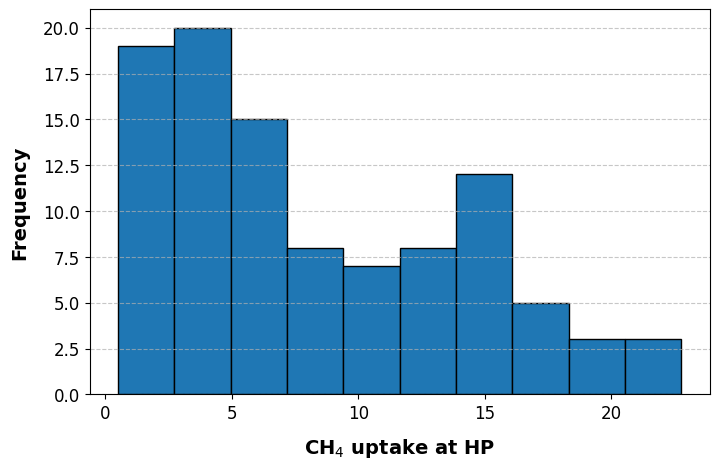

In [25]:
plt.figure(figsize = (8, 5), dpi = 100)
plt.hist(predictions, edgecolor = 'black')
plt.xlabel('CH$_4$ uptake at HP', fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold', labelpad = 10)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().patch.set_alpha(0.9)
plt.show()